### This notebook will contain code to take a comprehensive list of teachers in the state of Illinois in the 2015-2016 school year and find their ethnicities

In [1]:
import xlrd
import urllib.request

In [2]:
import re

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

Create a directory to hold downloaded files if you haven't already

```python
!mkdir ../../temp_files_projects
```

This python code will download the file:

```python
eis_teacher_data_file_url = "http://206.166.105.35/research/xls/2016-eis-public-dataset.xlsx"
destination_file_name = "../../temp_files_projects/eis_teacher_dataset_2016.xlsx"
urllib.request.urlretrieve(eis_teacher_data_file_url,destination_file_name)
```

In [ ]:
xlsl_file_location

In [5]:
xlsx_file_location = "../../temp_files_projects/eis_teacher_dataset_2016.xlsx"
xlsx_sheet_name = "EIS Public Data Set 2016"
teacher_data_df = pd.read_excel(xlsx_file_location,xlsx_sheet_name)

In [12]:
teacher_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183480 entries, 0 to 183479
Data columns (total 55 columns):
School Year                          183480 non-null int64
IEIN                                 183480 non-null int64
ID Number                            183480 non-null int64
Position Code                        183480 non-null int64
Position                             183480 non-null object
Last Name                            183479 non-null object
First name                           183480 non-null object
Middle Name                          134246 non-null object
Gender                               183480 non-null object
Race/Ethnicity                       183480 non-null object
Employer RCDT                        183480 non-null object
Region                               183480 non-null int64
County Code                          183480 non-null int64
District                             183480 non-null object
Type                                 183480 non-null in

I want to only look at High School Teachers

In [83]:
teacher_data_df_excel_hs = teacher_data_df_excel[teacher_data_df_excel['Grade Level Assignment']=='High School']
teacher_data_df_excel_hs= teacher_data_df_excel_hs[teacher_data_df_excel_hs['Position']=='Teacher']

In [165]:
teacher_data_df_excel_hs.shape

(31983, 55)

In [166]:
# There are 924 Schools Here of which I really need 224 ones since they have data on a Hispanic-White Achievement Gap
teacher_data_df_excel_hs['Primary Working Location Name'].unique().shape

(924,)

### Before I go any further, let's get the data that was scraped from the IRC site

In [31]:
school_data = pd.read_pickle('../../temp_files_projects/student_data_df.pkl')

In [108]:
school_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 8 columns):
Hispanic_White_Achievement_Gap    228 non-null float64
black_students                    228 non-null float64
black_teachers                    228 non-null float64
hispanic_students                 228 non-null float64
hispanic_teachers                 228 non-null float64
school_name                       228 non-null object
white_students                    228 non-null float64
white_teachers                    228 non-null float64
dtypes: float64(7), object(1)
memory usage: 14.3+ KB


In [109]:
school_data = school_data.drop_duplicates(subset=['school_name'])

In [164]:
school_data = school_data.reset_index(drop=True)
school_data.tail()

,Hispanic_White_Achievement_Gap,black_students,black_teachers,hispanic_students,hispanic_teachers,school_name,white_students,white_teachers
219,-13.0,0.5,0.3,33.0,8.2,WOODSTOCK NORTH HIGH SCHOOL (9-12),62.5,89.0
220,-4.0,3.1,0.2,13.8,4.1,YORK COMM HIGH SCHOOL (9-12),75.0,92.7
221,-18.0,6.4,1.1,15.7,3.0,YORKVILLE HIGH SCHOOL (9-12),71.1,95.1
222,-8.0,22.3,21.8,27.8,16.3,YOUNG MAGNET HIGH SCHOOL (7-12),29.9,51.4
223,-6.0,30.0,2.9,37.6,3.7,ZION-BENTON TWNSHP HI SCH (9-12),25.0,93.4


In [110]:
school_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224 entries, 0 to 227
Data columns (total 8 columns):
Hispanic_White_Achievement_Gap    224 non-null float64
black_students                    224 non-null float64
black_teachers                    224 non-null float64
hispanic_students                 224 non-null float64
hispanic_teachers                 224 non-null float64
school_name                       224 non-null object
white_students                    224 non-null float64
white_teachers                    224 non-null float64
dtypes: float64(7), object(1)
memory usage: 15.8+ KB


### Furthermore, let's clean these school names up a bit so that it matches the format of the excel data

In [181]:
sorted(school_data['school_name'])[:8]

['A B SHEPARD HIGH SCH (CAMPUS) (9-12)',
 'ACE TECHNICAL CHARTER HIGH SCHOOL (9-12)',
 'ADDISON TRAIL HIGH SCHOOL (9-12)',
 'ADLAI E STEVENSON HIGH SCHOOL (9-12)',
 'AIR FORCE ACAD HIGH SCHOOL (9-12)',
 'ALDEN-HEBRON HIGH SCHOOL (9-12)',
 'AMOS ALONZO STAGG HIGH SCHOOL (9-12)',
 'AMUNDSEN HIGH SCHOOL (9-12)']

In [182]:
sorted(teacher_data_df_excel_hs['Primary Working Location Name'].unique())[:23]

['A B Shepard High Sch (Campus)',
 'A-C Central High School',
 'ACTIONS Program',
 'ASSIST RSSP 12',
 'ASSIST TAOEP 12',
 'Abingdon-Avon High Sch',
 'Academy for Learning',
 'Academy for Secondary Education',
 'Ace Technical Charter High School',
 'Adams County RSSP',
 'Adams School',
 'Addison Trail High School',
 'Adlai E Stevenson High School',
 'Air Force Acad High School',
 'AlWood  Middle/High School',
 'Alden-Hebron High School',
 'Allendale School',
 'Altamont High School',
 'Alton High School',
 'Amandla Charter School',
 'Amboy High School',
 'Amos Alonzo Stagg High School',
 'Amundsen High School']

### Cursory glance says we should see what we can do with getting rid off the grade tags and converting hyphens to spaces instead

In [149]:
regex1 = re.compile('\(\S+\)', re.IGNORECASE)

In [199]:
cleaned_names_sd = school_data['school_name'].str.replace(regex1,' ').str.replace("-"," ").str.replace("  "," ")
cleaned_names_sd = cleaned_names_sd.str.lower().str.strip()

In [200]:
sorted(cleaned_names_sd)[:15]

['a b shepard high sch',
 'ace technical charter high school',
 'addison trail high school',
 'adlai e stevenson high school',
 'air force acad high school',
 'alden hebron high school',
 'amos alonzo stagg high school',
 'amundsen high school',
 'antioch comm high school',
 'arcola high school',
 'argo community high school',
 'auburn high school',
 'barrington high school',
 'bartlett high school',
 'batavia sr high school']

In [201]:
len(set(cleaned_names_sd))

224

In [208]:
cleaned_names_excel = pd.Series(teacher_data_df_excel_hs['Primary Working Location Name'].unique())
cleaned_names_excel = cleaned_names_excel.str.replace(regex1,' ').str.replace("-"," ").str.replace("  "," ")
cleaned_names_excel = cleaned_names_excel.str.lower().str.strip()

In [209]:
sorted(cleaned_names_excel)[:15]

['a b shepard high sch',
 'a c central high school',
 'abingdon avon high sch',
 'academy for learning',
 'academy for secondary education',
 'ace technical charter high school',
 'actions program',
 'adams county rssp',
 'adams school',
 'addison trail high school',
 'adlai e stevenson high school',
 'air force acad high school',
 'alden hebron high school',
 'allendale school',
 'altamont high school']

In [211]:
# Now let's check to see if we have all the schools present in both sets
len(set.intersection(set(cleaned_names_sd),set(cleaned_names_excel)))

220

In [212]:
#huh... seems like we don't. which one's are missing?
set(cleaned_names_sd)-set.intersection(set(cleaned_names_sd),set(cleaned_names_excel))

{'disney ii magnet hs',
 'horizon science acad mckinley park charter sch',
 'legacy acad of excellence charter sch',
 'ogden int high school'}

In [213]:
#looking through the names on the excel spreadsheet, it does seem like three of the schools are not on the list
#but 'horizon science acad mckinley park charter sch' is!
#Except, it's listed as 'horizon science acad mckinley park'
sorted(cleaned_names_excel)

['a b shepard high sch',
 'a c central high school',
 'abingdon avon high sch',
 'academy for learning',
 'academy for secondary education',
 'ace technical charter high school',
 'actions program',
 'adams county rssp',
 'adams school',
 'addison trail high school',
 'adlai e stevenson high school',
 'air force acad high school',
 'alden hebron high school',
 'allendale school',
 'altamont high school',
 'alton high school',
 'alwood middle/high school',
 'amandla charter school',
 'amboy high school',
 'amos alonzo stagg high school',
 'amundsen high school',
 'anna jonesboro high school',
 'annawan high school',
 'antioch comm high school',
 'arcola high school',
 'argenta oreana high school',
 'argo community high school',
 'armstrong high school',
 'arthur lovington atwood hammond high school',
 'ashton franklin center hs',
 'aspire alternative high school',
 'assist rssp 12',
 'assist taoep 12',
 'astoria high school',
 'athens sr high school',
 'auburn high school',
 'austin bus

In [217]:
# That's okay. We will give that a custom fix. Let's add a new cleaned_school_name column to the excel data frame
teacher_data_df_excel_hs['cleaned_school_name'] = teacher_data_df_excel_hs['Primary Working Location Name'].str.replace(regex1,' ').str.replace("-"," ").str.replace("  "," ").str.lower().str.strip()

/home/farhaan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [232]:
teacher_data_df_excel_hs.loc[teacher_data_df_excel_hs['cleaned_school_name']=='horizon science acad mckinley park',['cleaned_school_name']] = "horizon science acad mckinley park charter sch"

/home/farhaan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [240]:
#selecting only those schools that are present in our scraped data set
teacher_data_valid_schools_df = teacher_data_df_excel_hs.loc[teacher_data_df_excel_hs['cleaned_school_name'].isin(cleaned_names_sd),:]

In [264]:
teacher_count = teacher_data_valid_schools_df.groupby(by=['cleaned_school_name'])['First name'].count().reset_index()
teacher_count.columns = ['cleaned_school_name','total_teacher_count']
teacher_count.head(8)

,cleaned_school_name,total_teacher_count
0,a b shepard high sch,91
1,ace technical charter high school,1
2,addison trail high school,102
3,adlai e stevenson high school,233
4,air force acad high school,14
5,alden hebron high school,8
6,amos alonzo stagg high school,125
7,amundsen high school,49


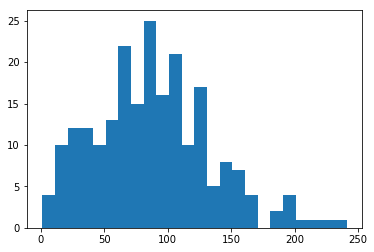

In [277]:
plt.hist(teacher_count.total_teacher_count,bins=range(min(teacher_count.total_teacher_count), max(teacher_count.total_teacher_count) + 10, 10));

In [282]:
teacher_count.loc[(teacher_count.total_teacher_count>= 1) & (teacher_count.total_teacher_count<=20)]

,cleaned_school_name,total_teacher_count
1,ace technical charter high school,1
4,air force acad high school,14
5,alden hebron high school,8
9,arcola high school,17
16,beecher high school,15
24,bowen high school,15
28,cambridge lakes charter school,1
34,chicago virtual charter school,18
85,horizon science acad mckinley park charter sch,9
89,intrinsic charter high school,19


In [253]:
teacher_data_valid_schools_df.groupby(by=['cleaned_school_name','Race/Ethnicity'])['Race/Ethnicity'].count()

cleaned_school_name                Race/Ethnicity                           
a b shepard high sch               Asian                                          1
                                   Black or African American                      3
                                   Hispanic or Latino                             3
                                   White                                         84
ace technical charter high school  Hispanic or Latino                             1
addison trail high school          American Indian or Alaska Native               1
                                   Asian                                          1
                                   Black or African American                      1
                                   Hispanic or Latino                             6
                                   Unknown                                        5
                                   White                                         88

In [233]:
sorted(teacher_data_df_excel_hs.loc[:,'cleaned_school_name'].unique())

['a b shepard high sch',
 'a c central high school',
 'abingdon avon high sch',
 'academy for learning',
 'academy for secondary education',
 'ace technical charter high school',
 'actions program',
 'adams county rssp',
 'adams school',
 'addison trail high school',
 'adlai e stevenson high school',
 'air force acad high school',
 'alden hebron high school',
 'allendale school',
 'altamont high school',
 'alton high school',
 'alwood middle/high school',
 'amandla charter school',
 'amboy high school',
 'amos alonzo stagg high school',
 'amundsen high school',
 'anna jonesboro high school',
 'annawan high school',
 'antioch comm high school',
 'arcola high school',
 'argenta oreana high school',
 'argo community high school',
 'armstrong high school',
 'arthur lovington atwood hammond high school',
 'ashton franklin center hs',
 'aspire alternative high school',
 'assist rssp 12',
 'assist taoep 12',
 'astoria high school',
 'athens sr high school',
 'auburn high school',
 'austin bus

In [251]:
teacher_data_df_excel.loc[teacher_data_df_excel['Primary Working Location Name']=='Ace Technical Charter High School'].iloc[:,]

,School Year,IEIN,ID Number,Position Code,Position,Last Name,First name,Middle Name,Gender,Race/Ethnicity,...,Subject Area 3,Subject Area 4,Subject Area 5,Subject Area 6,Subject Area 7,Subject Area 8,Subject Area 9,Subject Area 10,Subject Area 11,Subject Area 12
62772,2016,798003,22402,200,Teacher,Arana,Sean,K,Male,Hispanic or Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62773,2016,1001745,430507,110,Department Chair,Munro,Nicholas,F,Male,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62774,2016,173823,67669,250,Special Education Teacher,Clowers,Cherise,T,Female,Black or African American,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
p1= teacher_data_df_excel_hs['Primary Working Location Name'].unique().astype(str)

In [106]:
sorted(teacher_data_df_excel_hs['Primary Working Location Name'].unique().astype(str))

['A B Shepard High Sch (Campus)',
 'A-C Central High School',
 'ACTIONS Program',
 'ASSIST RSSP 12',
 'ASSIST TAOEP 12',
 'Abingdon-Avon High Sch',
 'Academy for Learning',
 'Academy for Secondary Education',
 'Ace Technical Charter High School',
 'Adams County RSSP',
 'Adams School',
 'Addison Trail High School',
 'Adlai E Stevenson High School',
 'Air Force Acad High School',
 'AlWood  Middle/High School',
 'Alden-Hebron High School',
 'Allendale School',
 'Altamont High School',
 'Alton High School',
 'Amandla Charter School',
 'Amboy High School',
 'Amos Alonzo Stagg High School',
 'Amundsen High School',
 'Anna-Jonesboro High School',
 'Annawan High School',
 'Antioch Comm High School',
 'Arcola High School',
 'Argenta-Oreana High School',
 'Argo Community High School',
 'Armstrong High School',
 'Arthur-Lovington-Atwood-Hammond High School',
 'Ashton-Franklin Center HS',
 'Aspire Alternative High School',
 'Astoria High School',
 'Athens Sr High School',
 'Auburn High School',
 '

In [101]:
len(set.intersection(set(pd1),set(sd1)))

214

In [103]:
set(sd1)-set.intersection(set(pd1),set(sd1))

{'disney ii ma', 'legacy acad ', 'mchenry east', 'ogden int hi'}

In [15]:
teacher_data_df_excel['Position'].unique()

array(['Curriculum Specialist', 'Teacher', 'Principal',
       'Technology Specialist', 'District Superintendent',
       'Library Information Specialist', 'Bilingual Education Teacher',
       'Special Education Teacher', 'Paraprofessional',
       'School  Counselor', 'Reading Teacher', 'Resource Teacher Reading',
       'Resource Teacher Elementary',
       'Speech Language Pathologist-non teaching', 'School Nurse',
       'Resource Teacher Math', 'Resource Teacher English/Language Arts',
       'Speech Language Pathology Teacher',
       'Assistant Special Education Director',
       'General Administrator or General Supervisor',
       'School Social Worker', 'Special Education Director',
       'In-Service Coordinator', 'Sign Language Interpreter',
       'School Psychologist',
       'Assistant/Associate District Superintendent',
       'Chief School Business Official', 'Instructional Coach',
       'Assistant Principal', 'Student Dean', 'Head Teacher',
       'Director Area Voc

In [26]:
schools_of_interest
teacher_data_df_excel['Primary Working Location Name']

array(['Early Childhood', 'Adams Co Juvenile Detention Cntr',
       'West Central Regional System', 'Brown County CUSD 1',
       'Brown County High School', 'Brown County Middle School',
       'Brown County Elementary School', 'Beardstown CUSD 15',
       'Beardstown Jr/Sr High School', 'Gard Elementary School',
       'Grand Ave Sch', 'Virginia CUSD 64', 'Virginia Jr/ Sr High School',
       'Virginia Jr High School', 'Virginia Elem School',
       'A-C Central CUSD 262', 'A-C Central High School',
       'A-C Central Middle School', 'A-C Central Elementary School',
       'Franklin CUSD 1', 'Franklin Jr/Sr High School',
       'Alexander Elem School', 'Franklin East Grade School',
       'Waverly CUSD 6', 'Waverly Junior/Senior High School',
       'Waverly Elementary School', 'Meredosia-Chambersburg CUSD 11',
       'Meredosia-Chambersburg High Sch', 'Meredosia-Chambersburg Jr High',
       'Meredosia-Chambersburg Elem Sch'], dtype=object)

In [147]:
sorted(school_data['school_name'])

['A B SHEPARD HIGH SCH (CAMPUS) (9-12)',
 'ACE TECHNICAL CHARTER HIGH SCHOOL (9-12)',
 'ADDISON TRAIL HIGH SCHOOL (9-12)',
 'ADLAI E STEVENSON HIGH SCHOOL (9-12)',
 'AIR FORCE ACAD HIGH SCHOOL (9-12)',
 'ALDEN-HEBRON HIGH SCHOOL (9-12)',
 'AMOS ALONZO STAGG HIGH SCHOOL (9-12)',
 'AMUNDSEN HIGH SCHOOL (9-12)',
 'ANTIOCH COMM HIGH SCHOOL (9-12)',
 'ARCOLA HIGH SCHOOL (7-12)',
 'ARGO COMMUNITY HIGH SCHOOL (9-12)',
 'AUBURN HIGH SCHOOL (9-12)',
 'BARRINGTON HIGH SCHOOL (9-12)',
 'BARTLETT HIGH SCHOOL (9-12)',
 'BATAVIA SR HIGH SCHOOL (9-12)',
 'BEARDSTOWN JR/SR HIGH SCHOOL (5-12)',
 'BEECHER HIGH SCHOOL (9-12)',
 'BELLEVILLE HIGH SCHOOL-EAST (9-12)',
 'BELLEVILLE HIGH SCHOOL-WEST (9-12)',
 'BELVIDERE HIGH SCHOOL (9-12)',
 'BELVIDERE NORTH HIGH SCH (9-12)',
 'BLOOM TRAIL HIGH SCHOOL (9-12)',
 'BLOOMINGTON HIGH SCHOOL (9-12)',
 'BOLINGBROOK HIGH SCHOOL (9-12)',
 'BOWEN HIGH SCHOOL (9-12)',
 'BRADLEY-BOURBONNAIS C HIGH SCHOOL (9-12)',
 'BREMEN HIGH SCHOOL (9-12)',
 'BUFFALO GROVE HIGH SCHOOL 

In [112]:
school_data['school_name'].str.replace(' ','').replace('-',)

0         A B SHEPARD HIGH SCH (CAMPUS) (9-12)
1     ACE TECHNICAL CHARTER HIGH SCHOOL (9-12)
2             ADDISON TRAIL HIGH SCHOOL (9-12)
3         ADLAI E STEVENSON HIGH SCHOOL (9-12)
4            AIR FORCE ACAD HIGH SCHOOL (9-12)
5              ALDEN-HEBRON HIGH SCHOOL (9-12)
6         AMOS ALONZO STAGG HIGH SCHOOL (9-12)
7                  AMUNDSEN HIGH SCHOOL (9-12)
8              ANTIOCH COMM HIGH SCHOOL (9-12)
9                    ARCOLA HIGH SCHOOL (7-12)
10           ARGO COMMUNITY HIGH SCHOOL (9-12)
11                   AUBURN HIGH SCHOOL (9-12)
12               BARRINGTON HIGH SCHOOL (9-12)
14                 BARTLETT HIGH SCHOOL (9-12)
15               BATAVIA SR HIGH SCHOOL (9-12)
16         BEARDSTOWN JR/SR HIGH SCHOOL (5-12)
17                  BEECHER HIGH SCHOOL (9-12)
18          BELLEVILLE HIGH SCHOOL-EAST (9-12)
19          BELLEVILLE HIGH SCHOOL-WEST (9-12)
20                BELVIDERE HIGH SCHOOL (9-12)
Name: school_name, dtype: object

In [ ]:
str.replace()

In [111]:
school_data['school_name'].str.lower().str[:12]

0      a b shepard 
1      ace technica
2      addison trai
3      adlai e stev
4      air force ac
5      alden-hebron
6      amos alonzo 
7      amundsen hig
8      antioch comm
9      arcola high 
10     argo communi
11     auburn high 
12     barrington h
14     bartlett hig
15     batavia sr h
16     beardstown j
17     beecher high
18     belleville h
19     belleville h
20     belvidere hi
21     belvidere no
22     bloom trail 
23     bloomington 
24     bolingbrook 
25     bowen high s
26     bradley-bour
27     bremen high 
28     buffalo grov
29     cambridge la
30     carl sandbur
           ...     
198    steinmetz co
199    sterling hig
200    streamwood h
201    sycamore hig
202    taft high sc
203    thornton fra
204    tinley park 
205    united twp h
206    urbana high 
207    vernon hills
208    victor j and
209    von steuben 
210    warren towns
211    waubonsie va
212    wauconda hig
213    waukegan hig
214    west aurora 
215    west leyden 
216    westmont hig


In [96]:
sd1 = school_data['school_name'].str.lower().str[:12]

In [47]:
teacher_data_df_excel['Primary Working Location Name'].unique().shape

(4793,)

In [50]:
teacher_data_df_excel['Primary Working Location Name'].str[:19].unique().shape

(4704,)

In [62]:
teacher_data_df_excel.loc[:,['Primary Working Location Name','Primary Working Location RCDTS']].sample(5)

,Primary Working Location Name,Primary Working Location RCDTS
90699,Madison Elementary School,190220440022013
104279,Wayne City High School,200961000260001
13549,Carleton W Washburne School,50160360021005
159227,Lincoln School,480721500252038
76306,Skinner Elem School,150162990252458


In [64]:
teacher_data_df.loc[13549,['Primary Working Location Name','Primary Working Location RCDTS']]

Primary Working Location Name     Carleton W Washburne School
Primary Working Location RCDTS               50160360021005.0
Name: 13549, dtype: object

In [81]:
teacher_data_df_excel['Primary Working Location RCDTS'] = teacher_data_df_excel['Primary Working Location RCDTS'].astype(str).apply(lambda x: "0"*(15-len(x))+x)

In [79]:
teacher_data_df_excel['Primary Working Location RCDTS'].astype(str).apply(len).unique()

array([14, 15])

In [ ]:
pd.Series.apply()